### Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
from collections import defaultdict

### Parameters

In [2]:
UPDATED_DATE = '4/21/20'

# Data Selection

### Import Datasets

In [3]:
cases = pd.read_csv('https://raw.githubusercontent.com/YohanJhaveri/Data-Mining-Project/master/time_series_global_confirmed.csv')
deaths = pd.read_csv('https://raw.githubusercontent.com/YohanJhaveri/Data-Mining-Project/master/time_series_global_deaths.csv')

gdp = pd.read_csv('https://raw.githubusercontent.com/YohanJhaveri/Data-Mining-Project/master/total_GDP(PPP).csv')

population = pd.read_csv('https://raw.githubusercontent.com/YohanJhaveri/Data-Mining-Project/master/population.csv')
population_density = pd.read_csv('https://raw.githubusercontent.com/YohanJhaveri/Data-Mining-Project/master/population_density%20(per%20sq%20km).csv')
population_over_60_years = pd.read_csv('https://raw.githubusercontent.com/YohanJhaveri/Data-Mining-Project/master/population_over_60%20(%25%20of%20population).csv')

urban_population = pd.read_csv('https://raw.githubusercontent.com/YohanJhaveri/Data-Mining-Project/master/urban_population(%25).csv')
rural_population = pd.read_csv('https://raw.githubusercontent.com/YohanJhaveri/Data-Mining-Project/master/rural_population(%25).csv')

median_age = pd.read_csv('https://raw.githubusercontent.com/YohanJhaveri/Data-Mining-Project/master/median_age.csv')
life_expectancy = pd.read_csv('https://raw.githubusercontent.com/YohanJhaveri/Data-Mining-Project/master/life_expectancy.csv')
smokers = pd.read_csv('https://raw.githubusercontent.com/YohanJhaveri/Data-Mining-Project/master/smoking(%25).csv')

hospital_beds_per_1000 = pd.read_csv('https://raw.githubusercontent.com/YohanJhaveri/Data-Mining-Project/master/hospital_beds_per_1000.csv')
health_expenditure_per_capita = pd.read_csv('https://raw.githubusercontent.com/YohanJhaveri/Data-Mining-Project/master/total_health_spending_per_capita(PPP).csv')
access_to_sanitation_facilities = pd.read_csv('https://raw.githubusercontent.com/YohanJhaveri/Data-Mining-Project/master/total_basic_sanitation_facilities%20(%25%20of%20population).csv')

measures = pd.read_csv('https://raw.githubusercontent.com/YohanJhaveri/Data-Mining-Project/master/measures.csv')


### Countries Dataset

In [4]:
countries = pd.DataFrame()

### Grouping COVID-19 Data by Country 

In [5]:
def group(df):
    df = df.drop(columns=['Lat','Long']) # removing redundant attributes like latitude and longitude
    df = pd.DataFrame(df.groupby(by = 'Country/Region').sum()) # grouping data by Country / Region to make the dataset consistent
    return df

cases = group(cases)
deaths = group(deaths)

### Adding COVID-19 Data

In [6]:
countries['Cases'] = cases[UPDATED_DATE]
countries['Deaths'] = deaths[UPDATED_DATE]

### Adding Demographic Data 

In [7]:
def combine_data(df):
    # collects most recent data of each country, starting at 2020
    # if 2020 data is not available, checks 2019 data and so on until data is found
    df.index = df['country']
    cols = list(reversed(df.columns))
    while int(cols[0]) > 2020: cols.pop(0)

    data = {}
    
    for i in df.index:
        for j in cols:
            if not np.isnan(df.loc[i][j]):
                data[i] = df.loc[i][j]
                break
    
    # dictionary that maps the naming convention of countries from the Johns Hopkins COVID-19 data to the Gapminder data 
    # aids in combining both datasets effectively
    
    replace = {
        'Cabo Verde': 'Cape Verde',
        'Congo (Brazzaville)': 'Congo, Rep.',
        'Congo (Kinshasa)': 'Congo, Dem. Rep.',
        'Czechia': 'Czech Republic',
        'Korea, South': 'South Korea',
        'Laos': 'Lao',
        'Saint Kitts and Nevis': 'St. Kitts and Nevis',
        'Saint Lucia': 'St. Lucia',
        'Saint Vincent and the Grenadines': 'St. Vincent and the Grenadines',
        'US': 'United States',
        'West Bank and Gaza': 'Palestine',
    }
    
    # adds data to a list in order of Johns Hopkins COVID-19 country indexes so that the data is aligned when it is added as an attribute
    
    values = []
    for i in countries.index:
        if i in replace: i = replace[i]
            
        if data.get(i, None) != None:
            values.append(data[i])
        else:
            values.append(None)
    
    return values

countries['GDP'] = combine_data(gdp)
countries['Population'] = combine_data(population)
countries['Population Density'] = combine_data(population_density)
countries['Urban Population'] = combine_data(urban_population)
countries['Rural Population'] = combine_data(rural_population)
countries['Life Expectancy'] = combine_data(life_expectancy)
countries['Median Age'] = combine_data(median_age)
countries['Smokers'] = combine_data(smokers)
countries['Population over 60 years'] = combine_data(population_over_60_years)
countries['Hospital Beds/1000'] = combine_data(hospital_beds_per_1000)
countries['Healthcare Expenditure per capita'] = combine_data(health_expenditure_per_capita)
countries['Access to Sanitation Facilities'] = combine_data(access_to_sanitation_facilities)

## Adding Safety Measures Data

In [8]:
measures = measures[['COUNTRY', 'MEASURE']]

for i in measures.index:
    measures.loc[i]['MEASURE'] = measures.loc[i]['MEASURE'].replace('\xa0','')

measures = measures.groupby(by="COUNTRY").agg(','.join)

data = {}
for country in measures.index:
    data[country] = ','.join(list(set( measures.loc[country]['MEASURE'].split(','))))
        
# dictionary that maps the naming convention of countries from the Johns Hopkins COVID-19 to the The Humanitarian Data Exchange data
# aids in combining both datasets effectively

replace = {
    'Brunei': 'Brunei Darussalam',
    'Congo (Brazzaville)': 'Congo',
    'Congo (Kinshasa)': 'Congo DR',
    'Czechia': 'Czech republic',
    'Vietnam': 'Viet Nam',
    'Moldova': 'Moldova Republic Of',
    "Cote d'Ivoire": "Côte d'Ivoire",
    'Korea, South': 'Korea DPR',
    'Laos': 'Lao PDR',
    'North Macedonia': 'North Macedonia Republic Of',
    'Russia': 'Russian Federation',
    'US': 'United States of America',
    'West Bank and Gaza': 'Palestine',
}

# adds data to a list in order of Johns Hopkins COVID-19 country indexes so that the data is aligned when it is added as an attribute

values = []
for i in countries.index:
    if i in replace: i = replace[i]

    if data.get(i, None) != None:
        values.append(data[i])
    else:
        values.append(None)

countries['Measures'] = values

# Data Extraction

In [9]:
def find_overall_growth_rate_by_day(df):
    old_df = df
    new_df = {}

    for i, n in enumerate(old_df.index):
        t = np.count_nonzero(old_df.iloc[i])
        # using the compound interest formula to calculate daily growth
        if t:    new_df[n] = (old_df.iloc[i][-1] / old_df.iloc[i][-t])**(1/t) - 1 
        # if there has been no growth, set growth rate to zero
        else:    new_df[n] = 0
    
    # multiply result by 100 to convert to percent
    return pd.Series(new_df) * 100
        
countries['GDP/Capita'] = countries['GDP'] / countries['Population']
countries['Cases/1000'] = (countries['Cases'] * 1000) / countries['Population']
countries['Deaths/1000'] = (countries['Deaths'] * 1000) / countries['Population']
countries['Mortality'] = np.divide(countries['Deaths'], countries['Cases']) * 100
countries['Cases Daily Growth Rate'] = find_overall_growth_rate_by_day(cases)
countries['Deaths Daily Growth Rate'] = find_overall_growth_rate_by_day(deaths)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  


# Data Pre-processing

### Manual Pre-processing

In [10]:
# Deleting columns that do not pertain to countries and instead correspond to cruise ships
countries = countries.drop(index=['Diamond Princess', 'MS Zaandam'])

### Correcting Zero Division Errors

In [11]:
# Zero division errors could have occured while calculating the daily growth rate
countries = countries.apply(lambda x: x.replace(float('inf'), 0))

### Imputing Missing Data

In [12]:
# nan values are imputed with attribute mean using SimpleImputer

from sklearn.impute import SimpleImputer
measures = countries['Measures']
countries = countries.drop(columns=['Measures'])

# initializing the imputer
impute = SimpleImputer(missing_values=np.nan, strategy='mean')

# imputing the data
imputed_countries = pd.DataFrame(impute.fit_transform(countries))

# adding the same index and column names to returned numpy array 
imputed_countries.index = countries.index
imputed_countries.columns = countries.columns
countries = imputed_countries
countries['Measures'] = measures

### Scaling

In [13]:
# standard scaling is performed on the data to prevent skewing of the distance metric
from sklearn.preprocessing import StandardScaler

# initializing the scaler
scaler = StandardScaler()

# scaling the relative epidimiological data which will be used to form clusters
data = scaler.fit_transform(np.array(countries[['Mortality', 'Cases Daily Growth Rate', 'Deaths Daily Growth Rate']]))

# Data Mining

## Correlation Analysis

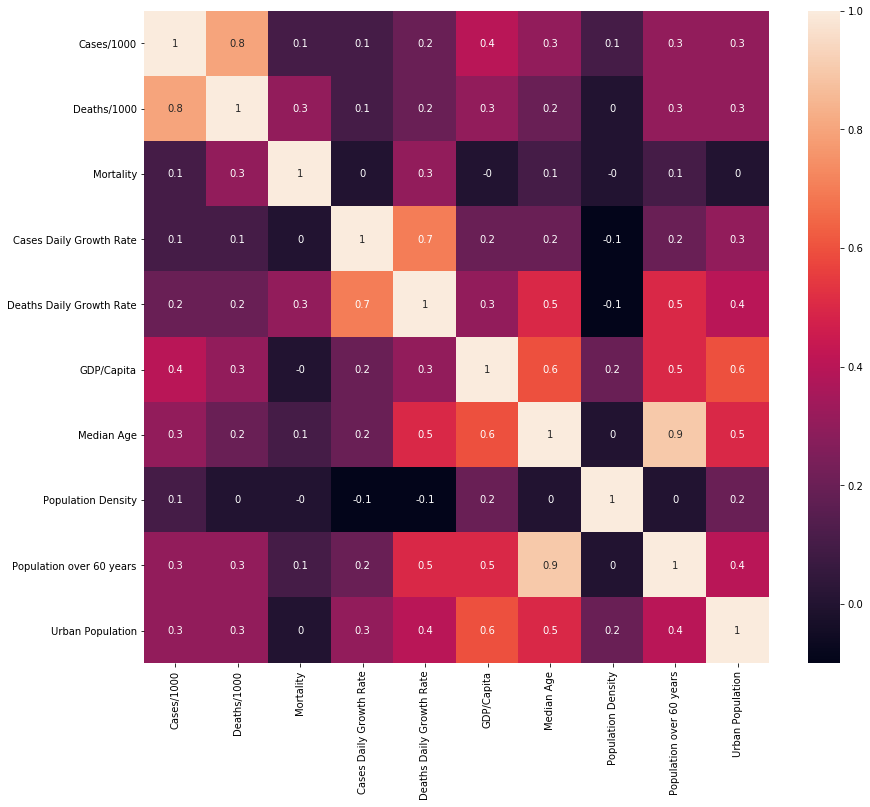

In [15]:
countries_healthcare = countries[['Cases/1000', 'Deaths/1000', 'Mortality', 'Cases Daily Growth Rate', 'Deaths Daily Growth Rate', 'Life Expectancy', 'Smokers', 'Hospital Beds/1000', 'Healthcare Expenditure per capita', 'Access to Sanitation Facilities']]
countries_demographics = countries[['Cases/1000', 'Deaths/1000', 'Mortality', 'Cases Daily Growth Rate', 'Deaths Daily Growth Rate', 'GDP/Capita', 'Median Age', 'Population Density', 'Population over 60 years', 'Urban Population']] 

fig_dims = (14, 12)
fig, ax = plt.subplots(figsize=fig_dims)
correlation_matrix = np.around(countries_demographics.corr(), 1)
seaborn.heatmap(correlation_matrix, annot=True)
plt.show()

## K-Means 

### Clustering

In [16]:
# Clustering into 3 clusters using epidemiological data 
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(data)
result = kmeans.predict(data)
countries['Cluster'] = result

### Evaluation

In [17]:
# Using the Silhouette Coefficient to evaluate clustering 
from sklearn.metrics import silhouette_score
silhouette_score(data, result, metric='euclidean')

0.39378031102411104

### Visualization

In [18]:
countries[countries['Cluster'] == 0].index

Index(['Australia', 'Azerbaijan', 'Bahrain', 'Benin', 'Bhutan', 'Botswana',
       'Brunei', 'Burma', 'Cabo Verde', 'Cambodia', 'Central African Republic',
       'Chad', 'China', 'Congo (Brazzaville)', 'Costa Rica', 'Dominica',
       'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 'Fiji', 'Gabon',
       'Georgia', 'Grenada', 'Guatemala', 'Guinea-Bissau', 'Haiti', 'Holy See',
       'Iceland', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Korea, South',
       'Kosovo', 'Laos', 'Lebanon', 'Libya', 'Liechtenstein', 'Madagascar',
       'Malaysia', 'Maldives', 'Malta', 'Mauritius', 'Monaco', 'Mongolia',
       'Montenegro', 'Mozambique', 'Namibia', 'Nepal', 'Oman',
       'Papua New Guinea', 'Paraguay', 'Rwanda', 'Saint Kitts and Nevis',
       'Saint Lucia', 'Saint Vincent and the Grenadines',
       'Sao Tome and Principe', 'Senegal', 'Seychelles', 'Sierra Leone',
       'Singapore', 'Slovakia', 'South Sudan', 'Sri Lanka', 'Taiwan*',
       'Thailand', 'Timor-Leste', 'Uganda',

In [19]:
countries[countries['Cluster'] == 1].index

Index(['Afghanistan', 'Albania', 'Andorra', 'Argentina', 'Armenia', 'Austria',
       'Bangladesh', 'Belarus', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil',
       'Bulgaria', 'Burkina Faso', 'Cameroon', 'Canada', 'Chile', 'Colombia',
       'Congo (Kinshasa)', 'Cote d'Ivoire', 'Croatia', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador',
       'El Salvador', 'Estonia', 'Finland', 'Germany', 'Ghana', 'Greece',
       'Guinea', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel',
       'Kenya', 'Kuwait', 'Kyrgyzstan', 'Latvia', 'Lithuania', 'Luxembourg',
       'Mali', 'Mexico', 'Moldova', 'Morocco', 'Netherlands', 'New Zealand',
       'Niger', 'Nigeria', 'North Macedonia', 'Norway', 'Pakistan', 'Panama',
       'Peru', 'Poland', 'Portugal', 'Qatar', 'Romania', 'Russia',
       'Saudi Arabia', 'Serbia', 'Slovenia', 'Somalia', 'South Africa',
       'Spain', 'Switzerland', 'Tanzania', 'Tunisia', 'Turkey', 'US',
       'Ukraine', 'Uruguay

In [20]:
countries[countries['Cluster'] == 2].index

Index(['Algeria', 'Angola', 'Antigua and Barbuda', 'Bahamas', 'Barbados',
       'Belgium', 'Belize', 'Burundi', 'Egypt', 'France', 'Gambia', 'Guyana',
       'Honduras', 'Hungary', 'Italy', 'Liberia', 'Malawi', 'Mauritania',
       'Nicaragua', 'Philippines', 'San Marino', 'Sudan', 'Suriname', 'Sweden',
       'Syria', 'Togo', 'Trinidad and Tobago', 'United Kingdom', 'Zimbabwe'],
      dtype='object', name='Country/Region')

In [21]:
countries.groupby(by="Cluster").mean()

,Cases,Deaths,GDP,Population,Population Density,Urban Population,Rural Population,Life Expectancy,Median Age,Smokers,Population over 60 years,Hospital Beds/1000,Healthcare Expenditure per capita,Access to Sanitation Facilities,GDP/Capita,Cases/1000,Deaths/1000,Mortality,Cases Daily Growth Rate,Deaths Daily Growth Rate
Cluster,,,,,,,,,,,,,,,,,,,,
0,2080.586667,74.920000,4.260898e+11,3.595049e+07,717.214497,55.275040,44.353347,72.344047,28.183132,20.688816,10.687385,2.824281,788.756698,70.517312,14347.118970,0.454885,0.005376,1.173954,10.097249,3.062723
1,23516.405063,1256.493671,7.418698e+11,5.808452e+07,122.164488,66.139472,33.568799,75.470131,33.116306,22.560325,16.006844,3.153166,1457.974750,80.968062,19502.817172,0.807432,0.034372,3.601946,16.840045,14.310671
2,18844.206897,2485.724138,3.484531e+11,2.282668e+07,167.833103,55.610345,44.116207,73.270357,28.696348,19.485023,12.432771,2.406897,1098.917241,73.975862,13625.966683,0.960267,0.103197,11.100623,11.038629,8.893343


## Apriori

In [26]:
# running apriori to find the best safety measures countries with the slowest daily growth rate of cases have applied

def apriori(input, support):

    items = {}
    freqs = {}

    def find_count(itemset):
        itemset = [items[i] for i in itemset]
        return np.sum(np.prod(data[:, itemset], axis=1))

    def delete_keys(n):
        keys = list(freqs[n].keys())
        for key in keys:
            if freqs[n][key] < support:
                del freqs[n][key]


    transactions = []
    dictionary_count = 0

    for i in input['Measures']:
        if i:
            transaction = i.split(',')
            transactions.append(transaction)

            for item in transaction:
                if item not in items:
                    items[item] = dictionary_count
                    dictionary_count += 1

    data = np.zeros((len(transactions), len(items)))

    for i, transaction in enumerate(transactions):
        for item in transaction:
            data[i, items[item]] = 1

    freqs[1] = defaultdict(int)
    freqs[2] = defaultdict(int)

    for transaction in transactions:
        n = len(transaction)

        for i in range(n):
            key = (transaction[i], )
            freqs[1][key] += 1

            for j in range(i+1, n):
                key = (transaction[i], transaction[j])
                freqs[2][key] += 1

    delete_keys(1)
    delete_keys(2)

    n = 2
    
    while len(freqs[n]) > 2:
        freqs[n + 1] = {}
        keys = list(freqs[n].keys())

        for i in range(len(keys)):
            for j in range(i + 1, len(keys)):
                union = tuple(set(keys[i]).union(set(keys[j])))
                if union not in freqs[n + 1] and len(union) == (n + 1):
                    freqs[n + 1][union] = find_count(union)

        delete_keys(n + 1)
        n += 1
        
    for x in freqs:
        for y in freqs[x]:
            print(' | '.join([i for i in y]) + ' (' + str(int(freqs[x][y])) + ')\n')

# running apriori with a support of 15 on the safety measures of countries with a daily growth rate of cases at less than 8%
apriori(countries[countries['Cases Daily Growth Rate'] < 8][['Measures']], 12)

Schools closure (15)

International flights suspension (16)

Strengthening the public health system (12)

Health screenings in airports and border crossings (16)

Domestic travel restrictions (12)

Border closure (15)

Emergency administrative structures activated or established (12)

Limit public gatherings (15)

Introduction of isolation and quarantine policies (16)

General recommendations (12)

Visa restrictions (13)

Awareness campaigns (12)

Public services closure (14)

International flights suspension | Health screenings in airports and border crossings (15)

International flights suspension | Border closure (13)

International flights suspension | Limit public gatherings (14)

International flights suspension | Introduction of isolation and quarantine policies (14)

Health screenings in airports and border crossings | Border closure (12)

Health screenings in airports and border crossings | Limit public gatherings (13)

Health screenings in airports and border crossings | Intr

In [23]:
countries.to_csv('./countries.csv')

Text(0, 0.5, 'Cases Daily Growth Rate (%)')

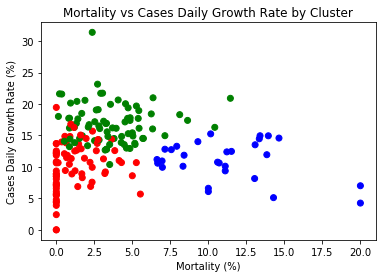

In [34]:
plt.scatter(countries['Mortality'], countries['Cases Daily Growth Rate'], color=[['red', 'green', 'blue'][i] for i in countries['Cluster']])
plt.title('Mortality vs Cases Daily Growth Rate by Cluster')
plt.xlabel('Mortality (%)')
plt.ylabel('Cases Daily Growth Rate (%)')